**Proceso de ETL: Steam_games**

In [2]:
#Importar librerías necesarias
# ==============================================================================
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Leer el archivo línea por línea y cargar cada línea como un objeto JSON
with open('../Archivos_Json/output_steam_games.json', 'r', encoding='utf-8') as archivo:
    data = [json.loads(line) for line in archivo]

# Convertir la lista de objetos JSON en un DataFrame
df_games = pd.DataFrame(data)
print(df_games.shape)
df_games

(120445, 13)


,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120440,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS"""
120441,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada
120442,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich
120443,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns"


- Duplicados Y Nulos

In [4]:
#Observar nulos
df_games.isnull().sum()

publisher       96362
genres          91593
app_name        88312
title           90360
url             88310
release_date    90377
tags            88473
reviews_url     88312
specs           88980
price           89687
early_access    88310
id              88312
developer       91609
dtype: int64

In [5]:
#Eliminar columnas irrelevantes
columnas_a_eliminar = ['publisher', 'url', 'tags','specs','early_access','reviews_url','title']
df_games = df_games.drop(columnas_a_eliminar,axis=1)

In [6]:
# Eliminar registros con todas las columnas nulas
df_games.dropna(how='all', inplace=True)
df_games.isnull().sum()

genres          3283
app_name           2
release_date    2067
price           1377
id                 2
developer       3299
dtype: int64

In [7]:
#Analizar nulos de la columna 'id'
df_games[df_games['id'].isnull()]

,genres,app_name,release_date,price,id,developer
88384,NaN,NaN,NaN,19.99,NaN,NaN
119271,"[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,2012-09-07,19.99,NaN,"Rocksteady Studios,Feral Interactive (Mac)"


In [8]:
#Analizo el registro 119271
df_games[df_games["app_name"] == "Batman: Arkham City - Game of the Year Edition"]

,genres,app_name,release_date,price,id,developer
89378,"[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,2012-09-07,19.99,200260,"Rocksteady Studios,Feral Interactive (Mac)"
119271,"[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,2012-09-07,19.99,NaN,"Rocksteady Studios,Feral Interactive (Mac)"


In [9]:
#Elimino registro 119271 por duplicado y eli,ino el registro 88384 por contener todos datos nulos salvo price
df_games.drop([119271,88384],inplace= True) 

In [10]:
#Busco y analizo los duplicados
columnas_para_verificar = ['id']
duplicados_columnas = df_games[df_games.duplicated(subset=columnas_para_verificar)]
duplicados_columnas

,genres,app_name,release_date,price,id,developer
102883,[Action],Wolfenstein II: The New Colossus,2017-10-26,59.99,612880,Machine Games


In [11]:
#Analizo el registro 102883
df_games[df_games["app_name"] == "Wolfenstein II: The New Colossus"]

,genres,app_name,release_date,price,id,developer
102204,[Action],Wolfenstein II: The New Colossus,2017-10-26,59.99,612880,Machine Games
102883,[Action],Wolfenstein II: The New Colossus,2017-10-26,59.99,612880,Machine Games


In [12]:
#Elimino registro 102883 por duplicado
df_games.drop(102883,inplace= True) 

In [13]:
#Vuelvo a revisar nulos
df_games.isnull().sum()

genres          3282
app_name           1
release_date    2066
price           1377
id                 0
developer       3298
dtype: int64

In [14]:
#Analizo nulo de app_game
df_games[df_games['app_name'].isnull()]

,genres,app_name,release_date,price,id,developer
90890,"[Action, Indie]",NaN,2014-08-26,NaN,317160,NaN


In [15]:
#Elimino registro 90890 por no contener ningún dato útil
df_games.drop(90890,inplace= True) 

In [16]:
#Vuelvo a revisar nulos
df_games.isnull().sum()

genres          3282
app_name           0
release_date    2066
price           1376
id                 0
developer       3297
dtype: int64

In [17]:
#Reemplazo nulos reemplazados por "Sin Datos"
df_games = df_games.fillna("Sin Datos")
df_games

,genres,app_name,release_date,price,id,developer
88310,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,4.99,761140,Kotoshiro
88311,"[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,Free To Play,643980,Secret Level SRL
88312,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017-07-24,Free to Play,670290,Poolians.com
88313,"[Action, Adventure, Casual]",弹炸人2222,2017-12-07,0.99,767400,彼岸领域
88314,Sin Datos,Log Challenge,Sin Datos,2.99,773570,Sin Datos
...,...,...,...,...,...,...
120440,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,2018-01-04,1.99,773640,"Nikita ""Ghost_RUS"""
120441,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,2018-01-04,4.99,733530,Sacada
120442,"[Indie, Racing, Simulation]",Russian Roads,2018-01-04,1.99,610660,Laush Dmitriy Sergeevich
120443,"[Casual, Indie]",EXIT 2 - Directions,2017-09-02,4.99,658870,"xropi,stev3ns"


- Transformación de Datos

In [18]:
#Tipos de Datos
df_games.dtypes

genres          object
app_name        object
release_date    object
price           object
id              object
developer       object
dtype: object

In [19]:
#Convierto las columnas "id" a tipo int
df_games["id"] = df_games["id"].astype("Int64")

In [20]:
#Es necesario transformar la columna "date_release" para poder extraer el año. 
# Extraer el año de la columna "release_date" y reemplazar los valores nulos con "sin dato"
df_games['Año_estreno'] = df_games['release_date'].str.extract(r'(\d{4})').fillna('Sin Datos')

# Elimino la columna release_date
df_games.drop(columns=['release_date'], inplace=True)
df_games

,genres,app_name,price,id,developer,Año_estreno
88310,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,4.99,761140,Kotoshiro,2018
88311,"[Free to Play, Indie, RPG, Strategy]",Ironbound,Free To Play,643980,Secret Level SRL,2018
88312,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Free to Play,670290,Poolians.com,2017
88313,"[Action, Adventure, Casual]",弹炸人2222,0.99,767400,彼岸领域,2017
88314,Sin Datos,Log Challenge,2.99,773570,Sin Datos,Sin Datos
...,...,...,...,...,...,...
120440,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,1.99,773640,"Nikita ""Ghost_RUS""",2018
120441,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,4.99,733530,Sacada,2018
120442,"[Indie, Racing, Simulation]",Russian Roads,1.99,610660,Laush Dmitriy Sergeevich,2018
120443,"[Casual, Indie]",EXIT 2 - Directions,4.99,658870,"xropi,stev3ns",2017


In [21]:
#Columna price: 
#Se muestra la composición de la columna
df_games["price"].unique()

array([4.99, 'Free To Play', 'Free to Play', 0.99, 2.99, 3.99, 9.99,
       18.99, 29.99, 'Sin Datos', 'Free', 10.99, 1.59, 14.99, 1.99, 59.99,
       8.99, 6.99, 7.99, 39.99, 19.99, 7.49, 12.99, 5.99, 2.49, 15.99,
       1.25, 24.99, 17.99, 61.99, 3.49, 11.99, 13.99, 'Free Demo',
       'Play for Free!', 34.99, 74.76, 1.49, 32.99, 99.99, 14.95, 69.99,
       16.99, 79.99, 49.99, 5.0, 44.99, 13.98, 29.96, 119.99, 109.99,
       149.99, 771.71, 'Install Now', 21.99, 89.99,
       'Play WARMACHINE: Tactics Demo', 0.98, 139.92, 4.29, 64.99,
       'Free Mod', 54.99, 74.99, 'Install Theme', 0.89, 'Third-party',
       0.5, 'Play Now', 299.99, 1.29, 3.0, 15.0, 5.49, 23.99, 49.0, 20.99,
       10.93, 1.39, 'Free HITMAN™ Holiday Pack', 36.99, 4.49, 2.0, 4.0,
       9.0, 234.99, 1.95, 1.5, 199.0, 189.0, 6.66, 27.99, 10.49, 129.99,
       179.0, 26.99, 399.99, 31.99, 399.0, 20.0, 40.0, 3.33, 199.99,
       22.99, 320.0, 38.85, 71.7, 59.95, 995.0, 27.49, 3.39, 6.0, 19.95,
       499.99, 16.06, 4

In [22]:
#Se muestran dos registros problematicos
df_games[(df_games["price"] == 'Starting at $499.00') | (df_games["price"] == 'Starting at $449.00')]

,genres,app_name,price,id,developer,Año_estreno
113310,Sin Datos,Syber Steam Machine,Starting at $499.00,353420,Sin Datos,2015
113311,Sin Datos,Alienware Steam Machine,Starting at $449.00,353390,Sin Datos,2015


In [23]:
#Modifico los datos asumiendo price como el precio inicial
df_games.loc[df_games["price"] == 'Starting at $499.00', "price"] = '499.00'
df_games.loc[df_games["price"] == 'Starting at $449.00', "price"] = '449.00'

In [24]:
#Columna price: 
#El resto de los valores strings que el juego es gratis
#Se define la función para poder reemplazar los datos string de la columna "price" por flotantes 0.0

def cambio_a_float(valor):

    if pd.isna(valor): #esta parte de la función es para el caso de que no exista ningun string o float en el campo
        return 0.0
    try:
        flotante = float(valor) #si el valor es float lo conservo
        return flotante
    except (ValueError, TypeError): #si el valor es diferente retorno 0.0
        return 0.0
    
#Aplico esta función a la columna precio
df_games["price"] = df_games["price"].apply(cambio_a_float)

In [25]:
df_games.head()

,genres,app_name,price,id,developer,Año_estreno
88310,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,4.99,761140,Kotoshiro,2018
88311,"[Free to Play, Indie, RPG, Strategy]",Ironbound,0.00,643980,Secret Level SRL,2018
88312,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,0.00,670290,Poolians.com,2017
88313,"[Action, Adventure, Casual]",弹炸人2222,0.99,767400,彼岸领域,2017
88314,Sin Datos,Log Challenge,2.99,773570,Sin Datos,Sin Datos


- Valores Atipicos

In [26]:
print(df_games["price"].describe())

count    32131.000000
mean         8.514355
std         16.086231
min          0.000000
25%          1.990000
50%          4.990000
75%          9.990000
max        995.000000
Name: price, dtype: float64


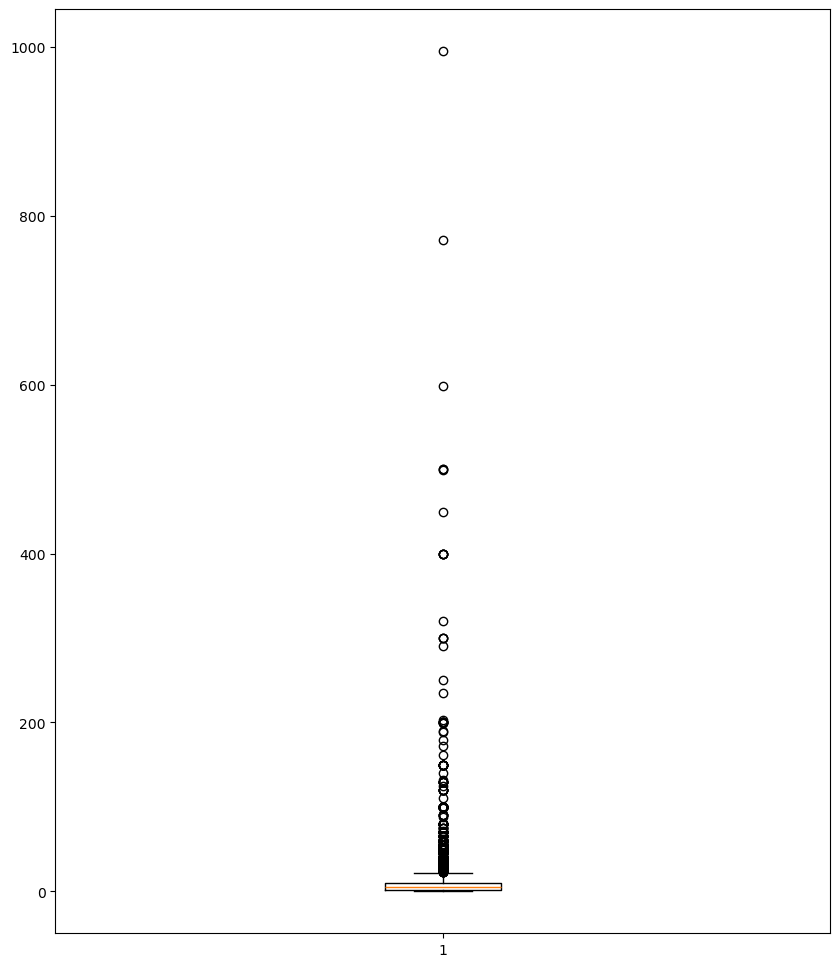

In [27]:
#Se analiza, boxplot
plt.figure(figsize=(10,12))
plt.boxplot(df_games["price"].dropna())
plt.show()

In [28]:
#Se observan los juegos mas caros par evaluar si son valores atípicos o no
df_games[df_games["price"] > 200]

,genres,app_name,price,id,developer,Año_estreno
90702,[Simulation],X-Plane 10 Global - 64 Bit,771.71,292180,Laminar Research,2014
92755,"[Animation &amp; Modeling, Design &amp; Illust...",MODO indie 10,299.99,401090,The Foundry,2015
95172,Sin Datos,ChessBase 13 Pro,234.99,377350,Chessbase,2016
97384,"[Animation &amp; Modeling, Design &amp; Illust...",GameMaker Studio 2 Mobile,399.99,585620,YoYo Games Ltd.,2017
97385,"[Animation &amp; Modeling, Design &amp; Illust...",GameMaker Studio 2 UWP,399.99,585610,YoYo Games Ltd.,2017
97727,[Video Production],MAGIX Video Pro X8 Steam Edition,399.00,598860,MAGIX Software GmbH,2017
100045,"[Animation &amp; Modeling, Design &amp; Illust...",Marvelous Designer 7 For Steam,320.00,707410,CLO Virtual Fashion,2017
100398,"[Animation &amp; Modeling, Design &amp; Illust...",Strata Spaces VR – Professional Edition Upgrade,995.00,719000,"Strata Mixed Reality, Inc.",2017
102065,[Video Production],MAGIX Video Pro X9 Steam Edition,399.00,750840,MAGIX Software GmbH,2017
102614,"[Animation &amp; Modeling, Design &amp; Illust...",CUR3D Maker Edition - Permission for commercia...,499.99,691560,RUHRSOURCE GmbH,2017


Observando las principales metricas estadisticas y los boxplots se descarta la existencia de valores atipicos en las variables numericas. Asumo que los valores altos de algunos items son razonables en este caso de negocio.

- Columna Genres

In [29]:
df_games["genres"]

88310         [Action, Casual, Indie, Simulation, Strategy]
88311                  [Free to Play, Indie, RPG, Strategy]
88312     [Casual, Free to Play, Indie, Simulation, Sports]
88313                           [Action, Adventure, Casual]
88314                                             Sin Datos
                                ...                        
120440                [Casual, Indie, Simulation, Strategy]
120441                            [Casual, Indie, Strategy]
120442                          [Indie, Racing, Simulation]
120443                                      [Casual, Indie]
120444                                            Sin Datos
Name: genres, Length: 32131, dtype: object

In [30]:
df_games.shape

(32131, 6)

In [31]:
#Con explode la columna genres tome cada valor que tiene almacenado y lo devuelva en un campo nuevo pero conservando el mismo id
df_games = df_games.explode("genres")
df_games = df_games.dropna(subset=["genres"])
df_games

,genres,app_name,price,id,developer,Año_estreno
88310,Action,Lost Summoner Kitty,4.99,761140,Kotoshiro,2018
88310,Casual,Lost Summoner Kitty,4.99,761140,Kotoshiro,2018
88310,Indie,Lost Summoner Kitty,4.99,761140,Kotoshiro,2018
88310,Simulation,Lost Summoner Kitty,4.99,761140,Kotoshiro,2018
88310,Strategy,Lost Summoner Kitty,4.99,761140,Kotoshiro,2018
...,...,...,...,...,...,...
120442,Racing,Russian Roads,1.99,610660,Laush Dmitriy Sergeevich,2018
120442,Simulation,Russian Roads,1.99,610660,Laush Dmitriy Sergeevich,2018
120443,Casual,EXIT 2 - Directions,4.99,658870,"xropi,stev3ns",2017
120443,Indie,EXIT 2 - Directions,4.99,658870,"xropi,stev3ns",2017


In [32]:
#Se cambia el nombre de la columna id por item_id
df_games.rename(columns={'id': 'item_id'}, inplace=True)

In [33]:
#Se guarda en formato Parquet
df_games.to_parquet('../Datasets/steam_games.parquet', engine='pyarrow')